<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>

<font color='blue'>
<br />
Евгений, привет! рад приветствовать тебя! <br />
<br />    

<br />
Меня зовут Николай. <br />И на этом этапе твоего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='orange'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако есть на что обратить внимание в плане применения техник, или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [84]:
# 1. Импорт библиотек

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


Загрузка всех необходимых библиотек

In [85]:
# 2. Импорт файла

taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Импорт файла

In [86]:
# 3. Визуальный осмотр данных

print (taxi.shape)
print (taxi.info())
display (taxi.describe())
display (taxi.head(5))


(26496, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Визуальный осмотр файла: никаких аномалий не видно

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
данные на базе)

# 2. Анализ

In [87]:
# 4. Ресемплирование к 1H

taxi = taxi.resample('1H').sum()
display (taxi.describe())
display (taxi.sort_values(by = 'num_orders', ascending = False).head(30))

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-13 01:00:00,273


1. Ресемплировал все к 1H. Еще раз посмотрел визуально - все логично с точки зрения данных

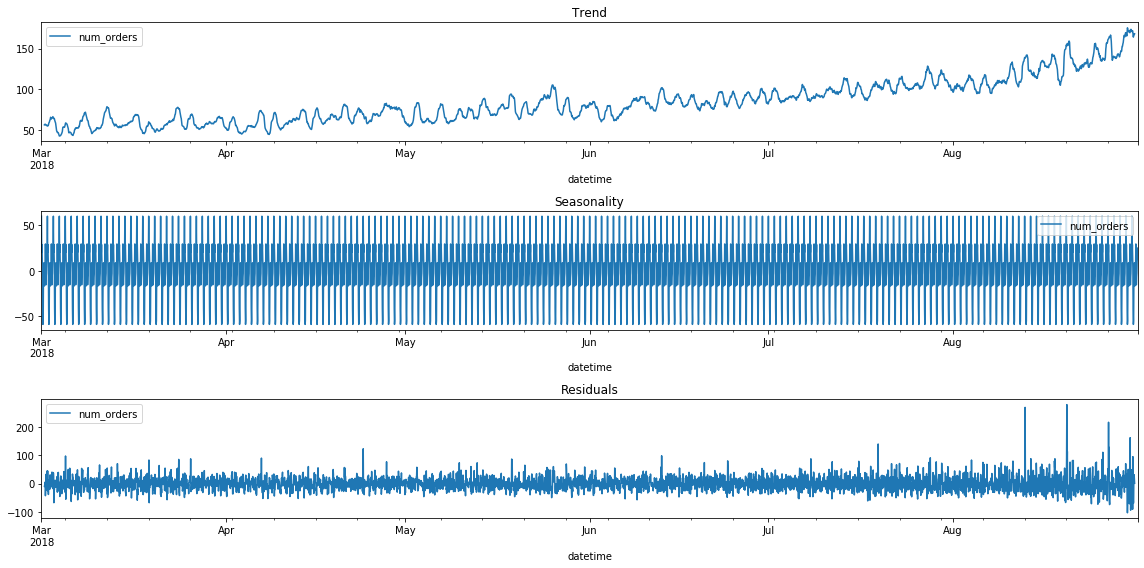

In [88]:
# 5. Декомпозиция и тренды

decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

1. Виден общий тренд увеличения заказов - в конце года рост заказов в три раза по сравнению с началом года
2. Чтобы выявить сезонность - надо углубляться в анализ дальше

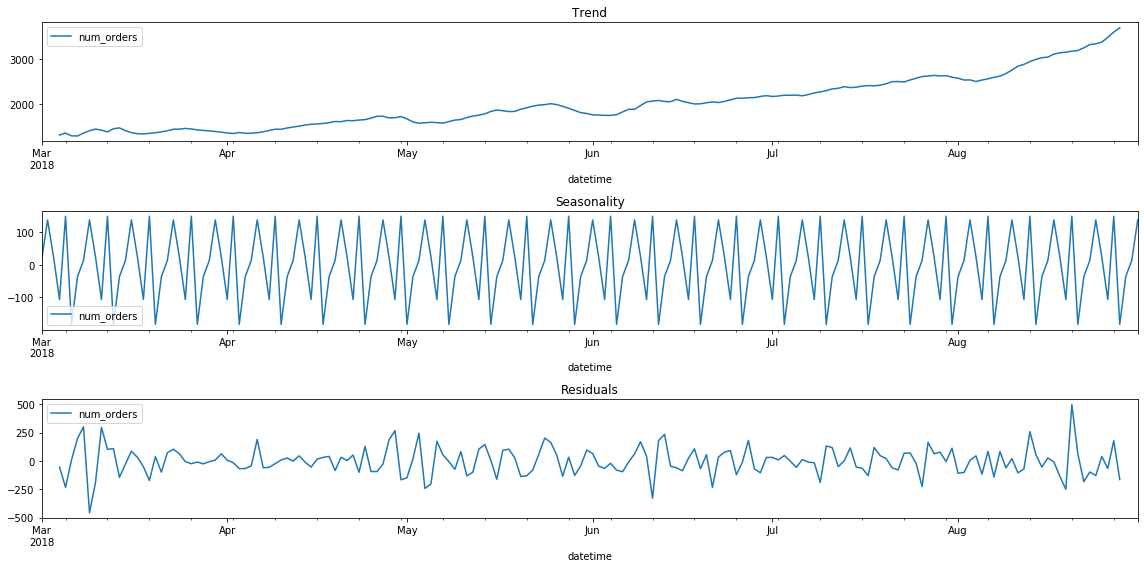

In [89]:
# 6. Декомпозиция по 1D

taxi1 = taxi.resample('1D').sum()

decomposed = seasonal_decompose(taxi1) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

1. Пока все то же самое. Будем углубляться дальше

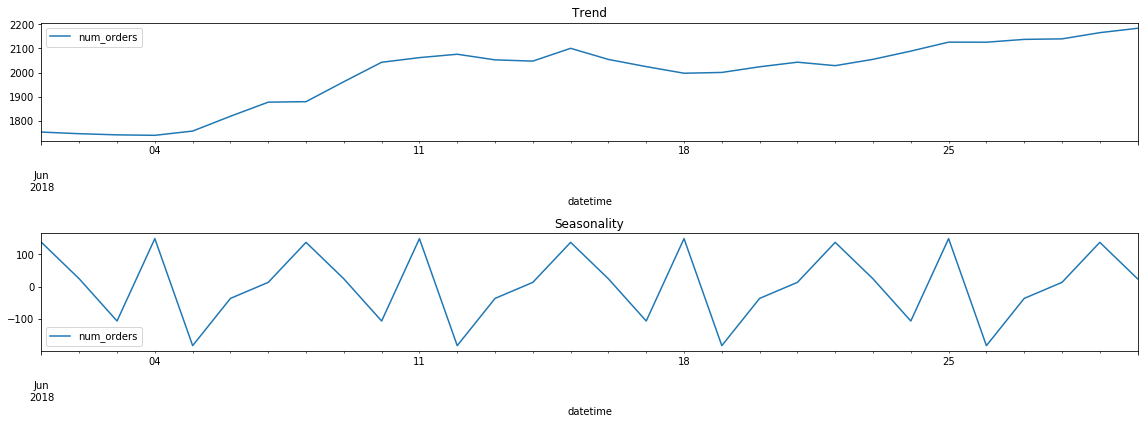

In [90]:
# 7. Декомпозиция по 1D - продолжение (по дням недели)

decomposed = seasonal_decompose(taxi1)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

1. По дням недели - пики пятница и понедельник (для меня понедельник неожиданно).
2. Наименьшое количество заказов - вторник (очень странно) и воскресенье, что логично.

3. Добавил внутримесячный тренд, как доказательство необходимости создания столбца .day для обучения модели

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-03-31 19:00:00,70
2018-03-31 20:00:00,59
2018-03-31 21:00:00,53


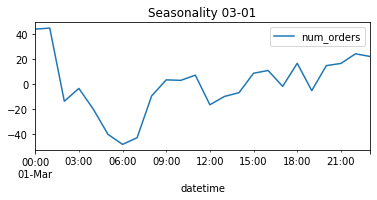

In [91]:
# 8. Декомпозиция по часам

taxi2 = taxi['2018-03-01':'2018-03-31']

display (taxi2)
decomposed = seasonal_decompose(taxi2) 

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-01-00':'2018-03-01-23'].plot(ax=plt.gca())
plt.title('Seasonality 03-01')
plt.show()


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Исследование - понятно, хорошо, что глянул график на коротком периоде<br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - очень нужный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это очень помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1)дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2)Но ведь есть ещё внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером (об этом Вы сказали) <br>
3)Ну и наконец есть месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных (и Вы об этом пишите) восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.
</font>

1. По часам - пик полночь, минимум 6 утра, далее постепенный рост.

In [92]:
# 9. Функция по созданию дополнительных столбцов

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Ты предлагаешь вот эти. А почему? Тут лучше ответить себе на этот вопрос?<br>
<font color='red'>
1) Фактор год: однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: аналогично году, у нас в истории всего один март, май....<br>
3) Фактор день: также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели:....<br>
5) Фактор час: ......<br>
6) Факто lag: .....<br>
7) Фактор rolling: ......<br>
    
Дай, пожалуйста, краткое описание, почему именно выбранные факторы взял в модель.<br>
Это один из ключевых моментов всей темы "временные ряды" - понимать составляющие ряда.<br>
Поэтому и прошу тебя сформулировать ответ на вопрос.

Создал функцию - по формированию дополнительных столбцов (декомпозиция даты и расчет скользящей средней) 
Ответы на комментарии:
1. Фактор - Год действительно не подходит, потому что для анализа нам предоставлены данные только в рамках одного года. Данный столбец удалю.
2. Фактор - Месяц. Несмотря на то, что каждый месяц у нас представлен только один раз, я оставлю данный параметр, так как значения в различных месяцах у нас все-таки отличаются, и вполне возможно, это поможет улучшить качество модели при ее обучении
3. Фактор - День. С одной стороны это просто последовательность чисел, с другой, например, возможно в начале месяца или конце, или середине - присутствуют некие закономерности, поэтому этот столбец также считаю полезным и оставляю. Например, в конце месяца - экономическая активность выше, следовательно должны чаще пользоваться услугами такси. Или, 5 или 10 числа, - день зарплаты - тоже самое. Это не так заметно на графике, там все перебивается днями недели, но все-таки, возможно, такая закономерность тоже есть.
Для этого при внутримесячном анализе добавил трендовый график, из которого четко видна внутримесячная динамика, не связанная с днями недели.
4. Фактор - день недели. Это уже объяснено на графике. Есть четкая зависимость от дня недели.
5. Фактор час - аналогично дню недели.
6. Фактор лаг - необходим для того, чтобы оценить влияние предыдущих значений ряда, на текущее значение. При обучении модели подбираем оптимальное количество столбцов, в которых учитываются предыдущие значения, при которых RMSE - наименьшее
7. Фактор rolling - рассчитываем скользящее среднее, предудущих значений и оцениваем влияние на качество модели.

# 3. Обучение

In [70]:

# 10. Линейная регрессия


rmse_min, lag_min, roll_min = 100000, 100000, 100000

for i in range (1,20,1):
    for j in range (1,20,1):
        
        make_features(taxi, i, j)


        train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
        train = train.dropna()

        features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
        target_train, target_test = train['num_orders'], test['num_orders']

        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
        rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
        if rmse_test < rmse_min:
            rmse_min = rmse_test
            lag_min = i
            roll_min = j
            
print("RMSE тестовой выборки: ", rmse_min, lag_min, roll_min)


'\n# 10. Линейная регрессия\n\n\nrmse_min, lag_min, roll_min = 100000, 100000, 100000\n\nfor i in range (1,20,1):\n    for j in range (1,20,1):\n        \n        make_features(taxi, i, j)\n\n\n        train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n        train = train.dropna()\n\n        features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n        target_train, target_test = train[\'num_orders\'], test[\'num_orders\']\n\n        model = LinearRegression()\n        model.fit(features_train, target_train)\n        predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n        rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5\n        if rmse_test < rmse_min:\n            rmse_min = rmse_test\n            lag_min = i\n            roll_min = j\n            \nprint("RMSE тестовой вы

RMSE линейной регрессии хуже таргета - 53.8. Продолжаем поиски оптимальной модели

In [71]:

# 11. Случайный лес

rmse_min, roll_min, est_min, depth_min = 100000, 0, 0, 0

for j in range (1,20,6):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']    
    for q in range (1,12,3):
        for z in range (1,300,15):
        
            model = RandomForestRegressor(random_state=12345, n_estimators=z, max_depth = q)
            model.fit(features_train, target_train)
            predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
            rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
            if rmse_test < rmse_min:
                rmse_min = rmse_test
                roll_min = j
                est_min = z
                depth_min = q
            print("RMSE тестовой выборки: ", rmse_test, j, z, q)    
print("лучшее RMSE тестовой выборки: ", rmse_min, roll_min, est_min, depth_min)


'\n# 11. Случайный лес\n\nrmse_min, roll_min, est_min, depth_min = 100000, 0, 0, 0\n\nfor j in range (1,20,6):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']    \n    for q in range (1,12,3):\n        for z in range (1,300,15):\n        \n            model = RandomForestRegressor(random_state=12345, n_estimators=z, max_depth = q)\n            model.fit(features_train, target_train)\n            predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n            rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5\n            if rmse_test < rmse_min:\n                rmse_min = rmse_test\

Случайный лес показал требуемый результат - 43.14, но, может быть, можно лучше?

In [72]:

# 11. Попробуем чере градиент LGBM

rmse_min, roll_min, est_min, depth_min, leaves_min = 100000, 0, 0, 0, 0

for j in range (13,20,8):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']    
    for q in range (1,14,4):
        for z in range (1,300,60):
            for w in range (30,300,60):
        
                model = LGBMRegressor(loss_function='RMSE', n_iterations = z, max_depth = q, num_leaves = w, min_data_in_leaf = 3)
                model.fit(features_train, target_train)
                predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)
                rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squared_error(target_test, predictions_test))**0.5
                if rmse_test < rmse_min:
                    rmse_min = rmse_test
                    roll_min = j
                    est_min = z
                    depth_min = q
                    leaves_min = w
                print("RMSE тестовой выборки: ", rmse_test, j, z, q, w)    
print("лучшее RMSE тестовой выборки: ", rmse_min, roll_min, est_min, depth_min, leaves_min)


'\n# 11. Попробуем чере градиент LGBM\n\nrmse_min, roll_min, est_min, depth_min, leaves_min = 100000, 0, 0, 0, 0\n\nfor j in range (13,20,8):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']    \n    for q in range (1,14,4):\n        for z in range (1,300,60):\n            for w in range (30,300,60):\n        \n                model = LGBMRegressor(loss_function=\'RMSE\', n_iterations = z, max_depth = q, num_leaves = w, min_data_in_leaf = 3)\n                model.fit(features_train, target_train)\n                predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)\n                rmse_train, rmse_test = (mean_squared_error(target_train, predictions_train))**0.5, (mean_squ

Это наилучший результат - 41.06

In [73]:

# 12. Еще на всякий случай проверим GridSearch


for j in range (1,20,6):
    make_features(taxi, j, j)
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
    target_train, target_test = train['num_orders'], test['num_orders']

    time0 = time.time()
    param_grid = {'n_estimators' : [x for x in range(1,300,15)], 'max_depth': [x for x in range(1,15,3)]} 
    clf = GridSearchCV (estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, n_jobs = -1)
    clf.fit (features_train, target_train)
    predictions_test = clf.predict(features_test)
    rmse_test = (mean_squared_error(target_test, predictions_test))**0.5
    time1 = time.time()
    print("RMSE тестовой выборки: ", rmse_test, clf.best_params_, time1-time0)


'\n# 12. Еще на всякий случай проверим GridSearch\n\n\nfor j in range (1,20,6):\n    make_features(taxi, j, j)\n    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)\n    train = train.dropna()\n\n    features_train, features_test = train.drop([\'num_orders\'], axis=1), test.drop([\'num_orders\'], axis=1)\n    target_train, target_test = train[\'num_orders\'], test[\'num_orders\']\n\n    time0 = time.time()\n    param_grid = {\'n_estimators\' : [x for x in range(1,300,15)], \'max_depth\': [x for x in range(1,15,3)]} \n    clf = GridSearchCV (estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, n_jobs = -1)\n    clf.fit (features_train, target_train)\n    predictions_test = clf.predict(features_test)\n    rmse_test = (mean_squared_error(target_test, predictions_test))**0.5\n    time1 = time.time()\n    print("RMSE тестовой выборки: ", rmse_test, clf.best_params_, time1-time0)\n'

Ожидаемый резльтат - близкий к RandomForest (очень долго отрабатывает)
Победитель LGBM с результатом RMSE - 41.06

In [93]:
#13 Модель с лучшими параметрами

make_features(taxi, 13, 13)
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
features_train, features_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
target_train, target_test = train['num_orders'], test['num_orders']    
model = LGBMRegressor(loss_function='RMSE', n_iterations = 61, max_depth = 5, num_leaves = 30, min_data_in_leaf = 3)
model.fit(features_train, target_train)
predictions_train, predictions_test = model.predict(features_train), model.predict(features_test)

target_test1 = pd.DataFrame(target_test)
target_test1['predict'] = predictions_test


Запускаем модель с лучшими параметрами, чтобы впоследствии сделать графическую проверку результатов

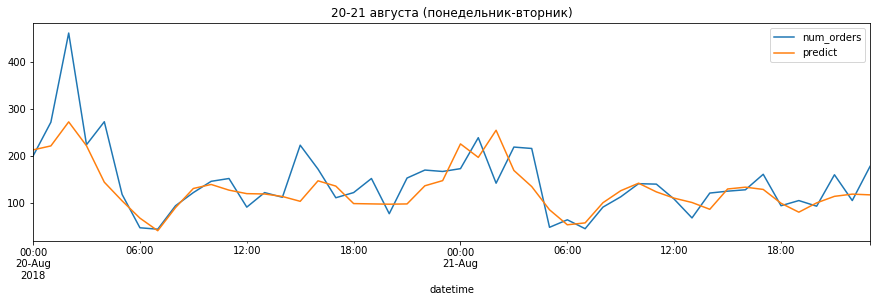

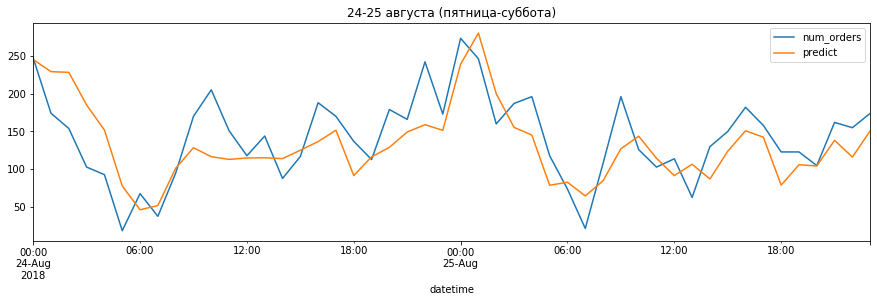

In [129]:
#14 Проверка на часовом графике

plt.figure(figsize=(15, 4))
target_test1['2018-08-20':'2018-08-21']['num_orders'].plot()
target_test1['2018-08-20':'2018-08-21']['predict'].plot()
plt.legend()
plt.title("20-21 августа (понедельник-вторник)")
plt.show()
plt.figure(figsize=(15, 4))
target_test1['2018-08-24':'2018-08-25']['num_orders'].plot()
target_test1['2018-08-24':'2018-08-25']['predict'].plot()
plt.legend()
plt.title("24-25 августа (пятница-суббота)")
plt.show()

1. Мне кажется, визуально, на часовом графике модель показывает себя достаточно неплохо.
2. Я специально сделал проверку и на рабочих днях (понедельник-вторник), и на выходных, предвыходных (пятница-суббота)
3. Основные тренды отлавливаются - провал к 6 утра, утренний пик (08-10 утра), ночной рост.
4. Что не ловится - резкие пики
5. Посмотрим, что происходит по дням недели

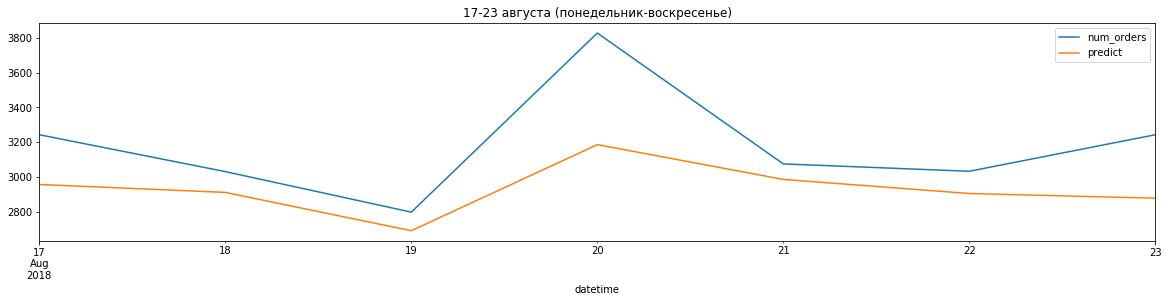

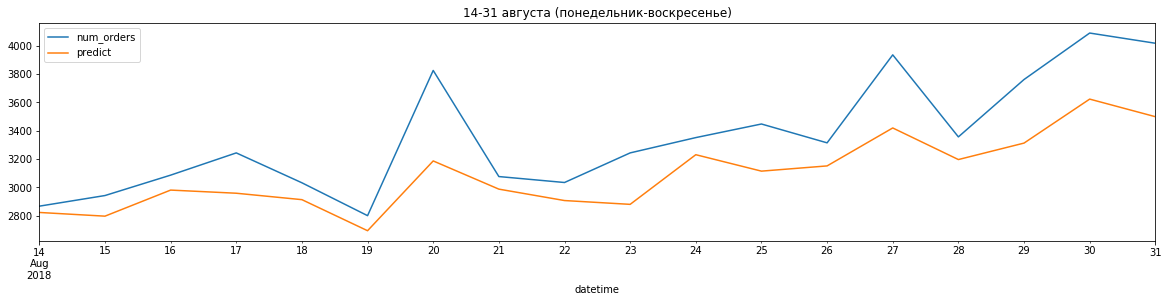

In [140]:
#15 Проверка на дневном графике

target_test2 = target_test1.resample('1D').sum()

plt.figure(figsize=(20, 4))
target_test2['2018-08-17':'2018-08-23']['num_orders'].plot()
target_test2['2018-08-17':'2018-08-23']['predict'].plot()
plt.legend()
plt.title("17-23 августа (понедельник-воскресенье)")
plt.show()

plt.figure(figsize=(20, 4))
target_test2['2018-08-14':'2018-08-31']['num_orders'].plot()
target_test2['2018-08-14':'2018-08-31']['predict'].plot()
plt.legend()
plt.title("14-31 августа (понедельник-воскресенье)")
plt.show()

Честно говоря, разочаровывающие данные
Кривая предсказаний находится значительно ниже фактической кривой
Конечно, 'сезонность' подтверждается. понедельник больше вторника и среды, рост к концу недели, но амплитуда совршенно не устраивает
Наверное, вы правы, это из-за того, что выборка у нас маленькая, и каждый месяц встречается только один раз, общий тренд на рост модель не схватывает?

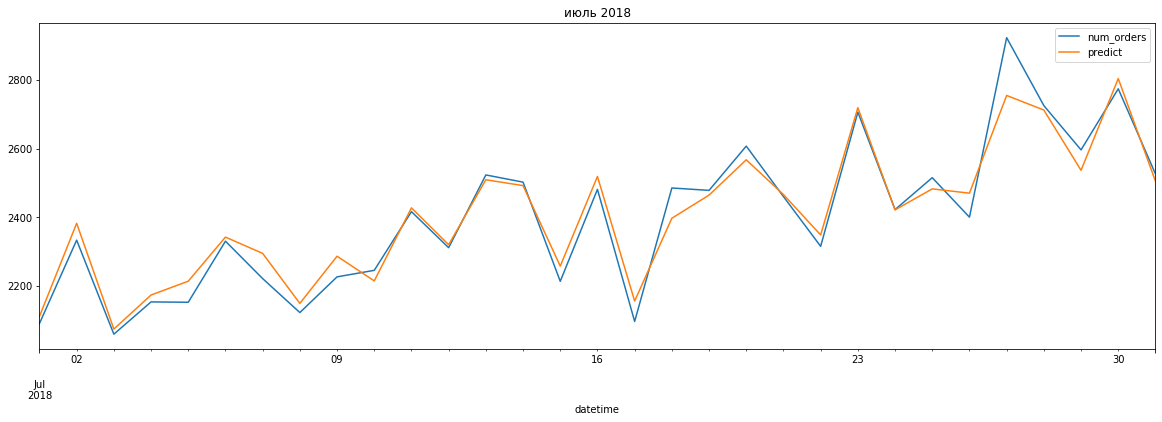

In [139]:
#16 Проверка на дневном графике (обучающая выборка)

target_train1 = pd.DataFrame(target_train)
target_train1['predict'] = predictions_train

target_train2 = target_train1.resample('1D').sum()

plt.figure(figsize=(20, 6))
target_train2['2018-07-01':'2018-07-31']['num_orders'].plot()
target_train2['2018-07-01':'2018-07-31']['predict'].plot()
plt.legend()
plt.title("июль 2018")
plt.show()

На обучающей выборке в месяц, предшествующий прогнозному - все выглядит адекватно.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Привет, Евгений! согласен, что с дневным прогнозом - интереснее смотрится<br>
Тебе удалось посмотреть ещё раз проект. Здорово.<br>
Я оставлю ещё нескольок комментариев:<br>
1) Фактор "скользящее среднее" =1 - это просто сдвиг столбца на одну строку вниз. По сути, это тоже самое, что lag=1. Идея скользящего среднего - усреднить несколько точек, чтобы выделить что-то похожее на тренд. Поэтому брать можно за пол-суто, за сутки. Как вараинт.<br><br>
2) Lag: ты прав, его называют ещё параметром авторегрессии. На бытовом уровне его можно понять так: допустим вчера мы собрались с друзьями и не много закусили.... повлияет ли это на сегодняшний настрой на жизнь? Скорее да)))) Так вот с авторегрессией также. Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - воалияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br>
    
<br>
Обычно так подбирают его.<br>
1) узнаём , какая у нас сезонность: в нашем случае их две - часовая и день недели (суточная и недельная)<br>
2) Узнайм, какой у нас тренд. пусть будет пока rolling (12) - пол суток<br>
3) строим модель. (без lag можно)<br>
4) строим график автокорреляции остатков (факт - прогноз). Если видим "зубья" на сезонных лагах: 24, 24*7 - то мы плохо жанной моделью учли сезонность.<br> Если высокий "зуб" на на первом лаге, то ндо вводить в модель фактор lag=1.<br> и перестроить модель... 20 - это много. значение 1-3 - это в самый раз.<br><br>
    
Глянь ещё тему "анализ остатков" гден-нибудь в инете. Важный момент.<br><br>
    
Вообще, ключевое во что: данные факторы временного ряда - это не гиперпараметры, привычные нам из классических ML-моделей. Это- реальные факторы продаж. Поэтому подбирать их лучше не перебором, а осмысленно, пытаясь разобраться почему такая-то сезонность, такой-то тренд....<br>

Наша, ксати, модель плохо угадывает тренд. Это можно заложить.<br>
В общем, работы тут ещё... <br>

Если тема интересна, то однозначно интересно посмотреть разные практические истории вот здесь:<br>
https://ibf.org/knowledge - заморский институт бизнес-прогнозирования.<br>
Там и статьи можно накопать, и методы посмомтерть...<br>
УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!
   

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Евгений, с модельной частью справился хорошо!<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
    
Если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
    
Уверен, что сумев понять главную особенность временных рядов - составляющие ряда и их влияние на прогноз продаж, у тебя появится уверенный скил и по этой теме.<br>
Готов буду ответить на твои вопросы!<br>
<font color='red'>    
А пока попрошу тебя чуть скорректировать такие моменты:<br>
1) раскрой, пожалуйста, почему именно такие факторы для моделирования выбраны и именно с такими параметрами.<br>
2) Если будет возможность: выведи, пожалуйста графики факт/предсказанное на одном рисунке (обычный линейный график). Чтобы увидеть где основные не "попадалки" модели. Это один из основных инструментов анализа результатов моделирования временных рядов.<br>
Лучше выбрать масштаб, скажем, несколько дней, чтобы увиеть можо было и сравнить каждый час.<br>    
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Хотел бы оставить несколько идей для Ваших будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.

# 4. Тестирование

По факту - все уже оттестировано

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48